In [32]:
station='BSG'

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import tensorflow as tf
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [34]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [35]:
def prepare_trend(dataset, n_in, n_out, n_vars):
    values = dataset.values
    values = values.astype('float32')
    scaled = values
    reframed = series_to_supervised(scaled, n_in, n_out)
    values = data.values
    n_train = -365*24
    train = values[:n_train, :]
    test = values[n_train:, :]
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]    
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
    te_y = test_y
    max1 = []
    min1 = []
    for i in range (0,n_vars):
        max_x = np.max(train_X[:,0,i])
        min_x = np.min(train_X[:,0,i])
        max1.append(max_x)
        min1.append(min_x)
        for j in range (0,len(train_X)):
            train_X[j,:,i] = (train_X[j,:,i]-min_x)/(max_x-min_x)
        for k in range(0,len(test_X)):
            test_X[k,:,i] = (test_X[k,:,i]-min_x)/(max_x-min_x)
    max1=np.max(train_y[:,0])
    min1=np.min(train_y[:,0])
    return train_X, train_y, test_X, test_y,max1,min1

In [36]:
def prepare_data(dataset, n_in, n_out, n_vars, gamma):
    values = dataset.values
    values = values.astype('float32')
    scaled = values
    reframed = series_to_supervised(scaled, n_in, n_out)
    values = data.values
    n_train =-365*24
    train = values[:n_train, :]
    test = values[n_train:, :]
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]    
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
    te_y = test_y
    max1 = []
    min1 = []
    for i in range (0,n_vars):
        max_x = np.max(train_X[:,0,i])
        min_x = np.min(train_X[:,0,i])
        max1.append(max_x)
        min1.append(min_x)
        for j in range (0,len(train_X)):
            train_X[j,:,i] = (train_X[j,:,i]-min_x)/(max_x-min_x)
        for k in range(0,len(test_X)):
            test_X[k,:,i] = (test_X[k,:,i]-min_x)/(max_x-min_x)
    max1=np.max(train_y[:,0])
    min1=np.min(train_y[:,0])
    gamma = (gamma-min1)/(max1-min1)
    for i in range (0,n_out):
        for j in range (0,len(train_y)):
            train_y[j,i] = (train_y[j,i]-min1)/(max1-min1)
        for k in range(0,len(test_y)):
            test_y[k,i] = (test_y[k,i]-min1)/(max1-min1)
    return train_X, train_y, test_X, test_y, max1,min1,gamma

In [37]:
import math
def hloss(n_out,c):
    loss = 0.0
    if c >=0:
        loss = math.e**(c/(n_out+1))-1
    
    else:
        loss = math.e**(-c)-1
    return loss

def my_loss(y_true,y_pred):
    loss=0.0
    y_true = y_true
    y_pred = y_pred
  
    for i in range(0,len(y_pred)):
        c = y_pred[i,n_out-1]-y_true[i,n_out-1]
        b = y_true[i,n_out-1]
            
        if b < gamma:
            loss += c**2
        else:
            loss += hloss(n_out,c)
    loss=tf.cast(loss,tf.float32)
    return loss

In [64]:
def att_lstm(train_X, train_y, test_X, n_neurons, n_batch, n_epoch, loss='mse', optimizer='adam', repeats=1):
    model_list = []
    for i in range(repeats):
        # Design neural network
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(n_neurons, return_sequences=True))
        model.add(AttentionLayer())  # Add attention layer after LSTM
        model.add(Dense(train_y.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        #earlyStop = EarlyStopping(monitor='loss', min_delta=0, patience=50, mode='min', verbose=1, restore_best_weights=True)
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=False)
    return model

from keras.callbacks import EarlyStopping
def fit_lstm(train_X, train_y, test_X, n_neurons=96, n_batch=256, n_epoch=50, loss='mse', optimizer='adam', repeats=1):
    model_list = []
    for i in range(repeats):
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(train_y.shape[1]))
        model.compile(loss=my_loss, optimizer='adam')
        earlyStop = EarlyStopping(monitor='loss', min_delta=0, patience=5, mode='min', verbose=1, restore_best_weights = True)
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch,verbose=1, shuffle=False)  
    return model

In [40]:
def set_gamma(bin_size, data):
    min_val = min(data)
    max_val = max(data)
    bins_num = int((max_val - min_val) / bin_size) + 1
    
    counts, bins_edges = np.histogram(data, bins=bins_num)
    bin_ratios = counts / counts.sum()
    gamma = None
    for i in range(1, bins_num):
        if bin_ratios[i] < 1/bins_num and bin_ratios[i - 1] >= 1/bins_num and bin_ratios[i+1] < 1/bins_num:
            gamma = bins_edges[i]
            break
    gamma = round(gamma, 1)
    return gamma

In [12]:
dataset = read_csv(r'F:\weather\BSG.csv',parse_dates=['dt'],encoding='utf-8').set_index('dt')
from ewtpy import EWT1D
swh_values = dataset['swh'].values
imfs, mfb,boundaries = EWT1D(swh_values,N=4)

In [14]:
trend = imfs[:,0]
res = swh_values- imfs[:,0]

In [12]:
global max1
global min1
global n_out
global gamma
n_in = 24
n_out =24
n_vars = 6
n_neuron = 512
n_batch = 512
repeats = 1

In [13]:
dataset1 = dataset
dataset1['swh'] = trend
train_X, train_y, test_X,test_y1,max1,min1  = prepare_trend(dataset1,n_in, n_out,n_vars)

In [14]:
model = att_lstm(train_X, train_y, test_X, n_neuron, n_batch, n_epoch=200,repeats=1)
ours1 = model.predict(test_X)

Epoch 1/200
24/24 [==============================] - 4s 54ms/step - loss: 0.1274
Epoch 2/200
24/24 [==============================] - 1s 54ms/step - loss: 0.0888
Epoch 3/200
24/24 [==============================] - 1s 54ms/step - loss: 0.0653
Epoch 4/200
24/24 [==============================] - 1s 54ms/step - loss: 0.0507
Epoch 5/200
24/24 [==============================] - 1s 54ms/step - loss: 0.0748
Epoch 6/200
24/24 [==============================] - 1s 54ms/step - loss: 0.0711
Epoch 7/200
24/24 [==============================] - 1s 55ms/step - loss: 0.0691
Epoch 8/200
24/24 [==============================] - 1s 53ms/step - loss: 0.0604
Epoch 9/200
24/24 [==============================] - 1s 55ms/step - loss: 0.0426
Epoch 10/200
24/24 [==============================] - 1s 53ms/step - loss: 0.0188
Epoch 11/200
24/24 [==============================] - 1s 53ms/step - loss: 0.0100
Epoch 12/200
24/24 [==============================] - 1s 55ms/step - loss: 0.0181
Epoch 13/200
24/24 [=====

In [16]:
ours1 = ours1*(max1-min1)+min1
inv_y1 = test_y1*(max1-min1)+min1

In [42]:
bin_size = 0.1
gamma = set_gamma(bin_size,dataset['swh'].values)
dataset2 = dataset
#dataset2['swh'] = res
train_X, train_y, test_X,test_y2,max2,min2,gamma  = prepare_data(dataset2,n_in, n_out,n_vars,gamma)

In [44]:
model = fit_lstm(train_X, train_y, test_X,n_neuron, n_batch, n_epoch=200,repeats=1)
ours2 = model.predict(test_X)

Epoch 1/50
24/24 [==============================] - 10s 354ms/step - loss: 23.1811
Epoch 2/50
24/24 [==============================] - 8s 349ms/step - loss: 15.4129
Epoch 3/50
24/24 [==============================] - 8s 343ms/step - loss: 14.0122
Epoch 4/50
24/24 [==============================] - 8s 352ms/step - loss: 14.5941
Epoch 5/50
24/24 [==============================] - 9s 356ms/step - loss: 13.9097
Epoch 6/50
24/24 [==============================] - 8s 350ms/step - loss: 12.9946
Epoch 7/50
24/24 [==============================] - 8s 337ms/step - loss: 12.9595
Epoch 8/50
24/24 [==============================] - 8s 351ms/step - loss: 13.3193
Epoch 9/50
24/24 [==============================] - 8s 346ms/step - loss: 12.6058
Epoch 10/50
24/24 [==============================] - 8s 344ms/step - loss: 11.5257
Epoch 11/50
24/24 [==============================] - 8s 345ms/step - loss: 11.8959
Epoch 12/50
24/24 [==============================] - 8s 345ms/step - loss: 12.8027
Epoch 13/50


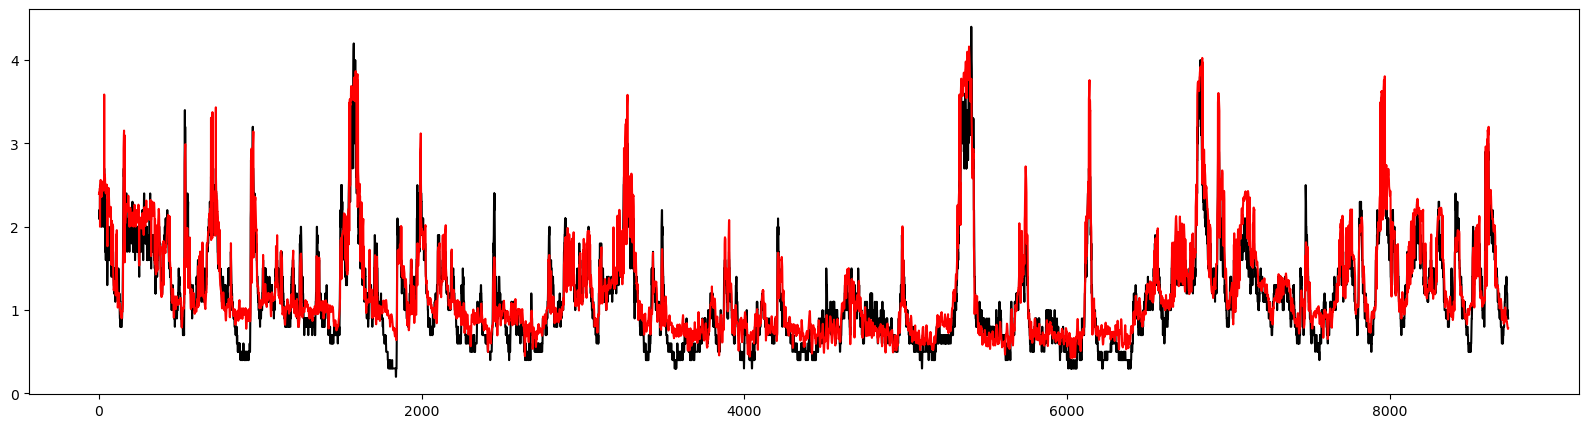

In [62]:
p=n_out
plt.figure(figsize=(20,5))
plt.plot(inv_y2[:-p,p-1],"-", label = 'Actual',color='black')
plt.plot(ours2[p:,p-1], "-",label = 'OURS',color='red')
#plt.plot(srf[:],'-',label = 'LSTM',color='orange')

In [47]:
ours2 = ours2*(max2-min2)+min2
inv_y2 = test_y2*(max2-min2)+min2

In [63]:
inv_yhat = ours[p:,-1]
y = inv_y[:-p,-1]
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
print(np.sqrt(mean_squared_error(y,inv_yhat)))
print(mean_absolute_error(y,inv_yhat))
print( r2_score(y,inv_yhat))

0.26444873
0.2026086
0.8018013040196893
